Standard parameters can be changed for different results but there is no need to do it

In [1]:
from TextRecognition import *

#values can be modified for different results --> following are the standard parameters

all_possible_words = ["Start", "Ziel"]

FILETEXTTEST = "./TestImages/Test8.png"
MODELPATH = "LetterNeuralNetNE5BS26LR0001ACC92.pth"

# following parameters need to be customized to the letter size
padding = 0.3 # percentage from given image
word_min_accuracy = 0.5
line_diff = 0.1

Before the word/letter recognition can be used the original image is being transformed into an inverted gray_scale image, so it can be used by the method for finding contours.

After finding the contours the image inside of it is cropped and then later used as an input for the trained model.
First the cropped image get size transformed, a black border, rotated and flipped to have the same format as the training images.

Then the tensor of the image is modified, so it can be used as an input.
First the tensor is 2 times unsqueezed to have the same size as the input tensors for training -> (batchsize, colorchannel, size, size)

by creating a tensor from a grayscale image the size of the tensor is (size, size) because the grayscale image has only 1 color channel, and it wouldn't change the resulting tensor

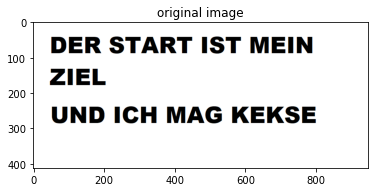

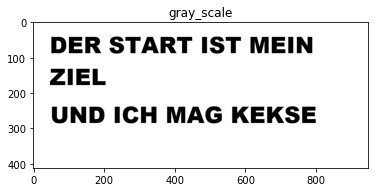

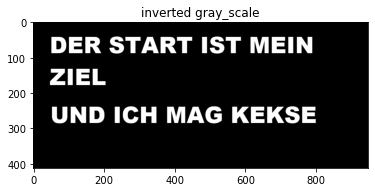

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


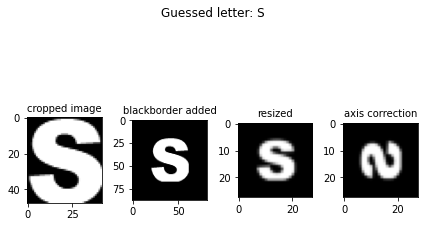

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


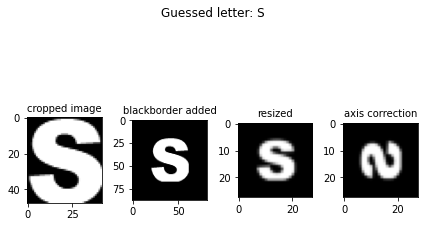

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


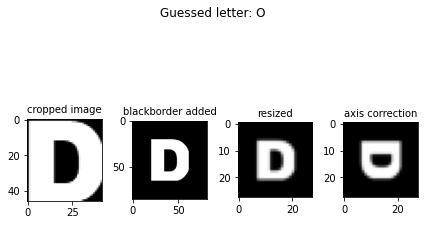

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


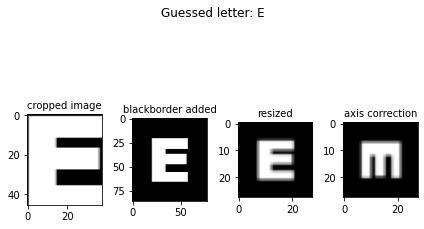

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


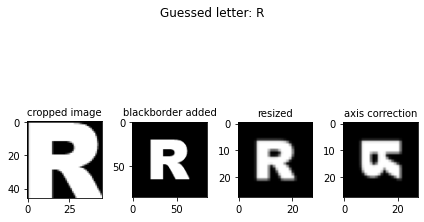

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


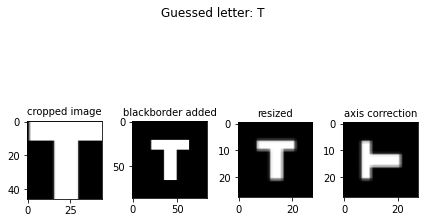

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


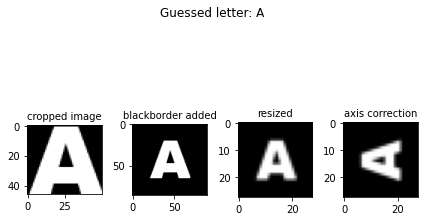

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


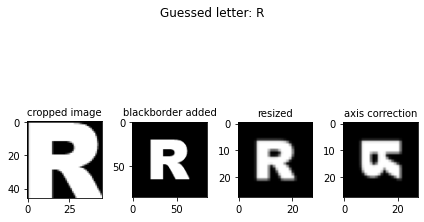

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


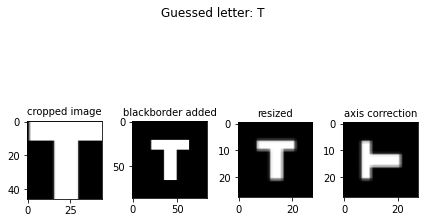

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


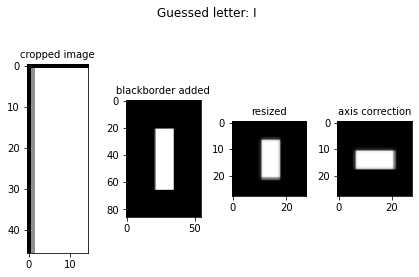

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


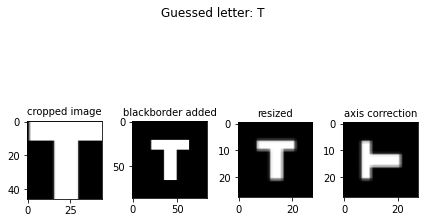

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


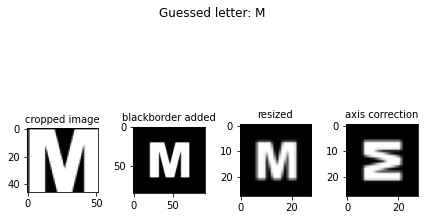

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


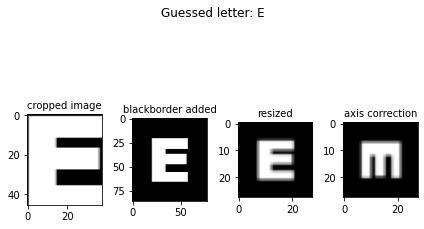

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


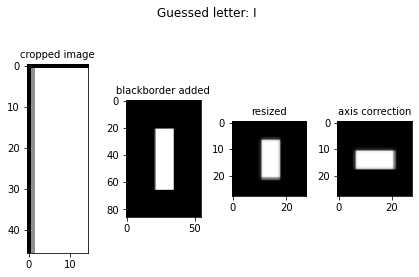

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


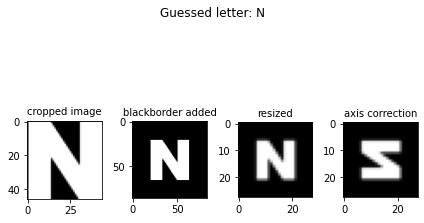

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


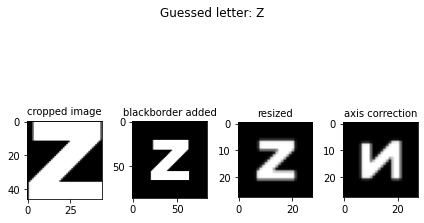

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


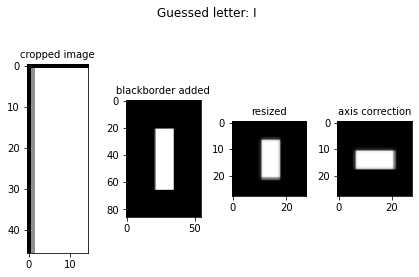

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


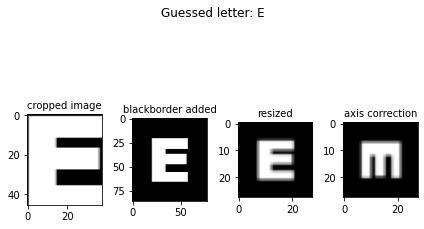

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


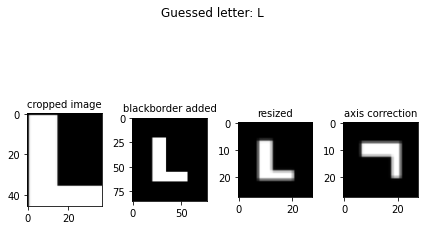

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


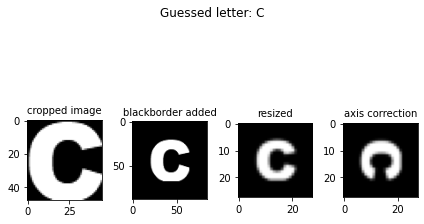

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


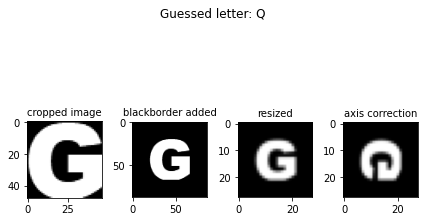

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


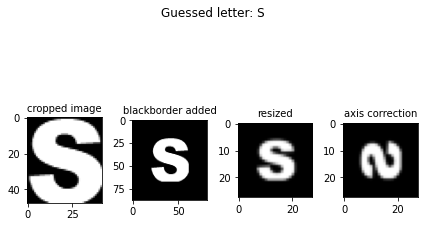

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


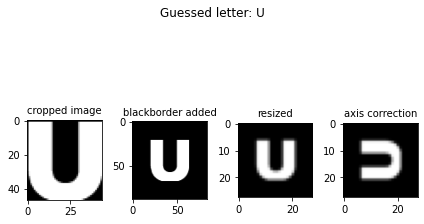

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


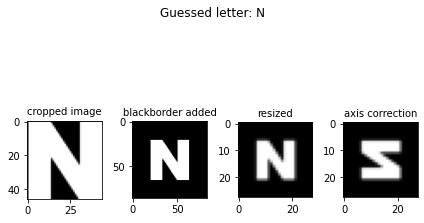

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


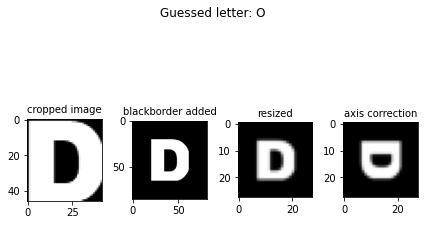

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


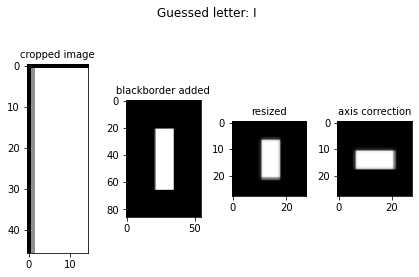

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


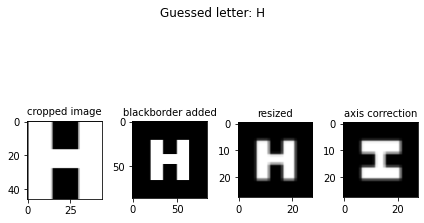

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


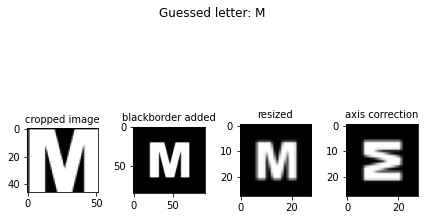

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


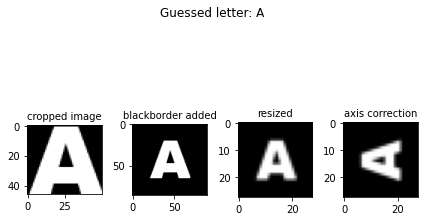

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


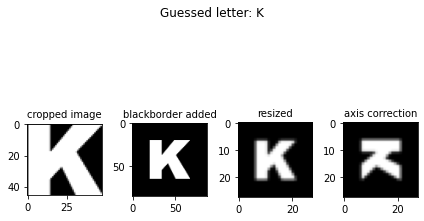

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


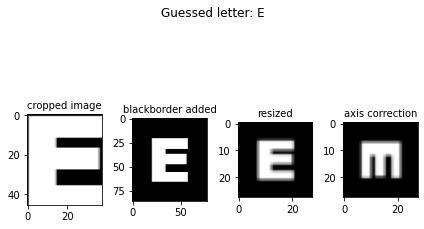

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


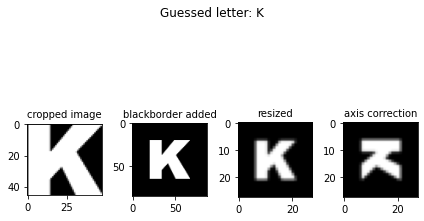

before tensor transformation: torch.Size([28, 28])
after tensor transformation: torch.Size([1, 1, 28, 28])


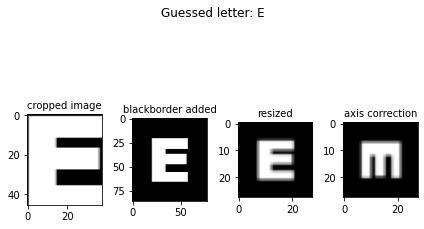

In [2]:
img = setup()
copy_img = np.copy(img)
b_img, all_boundingboxes = drawBoundingBox(img)

After the transformation each contour gets inserted into the model resulting in the letter recognition

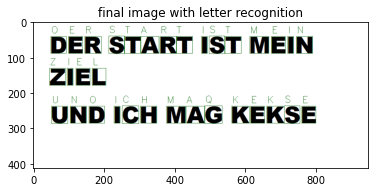

In [3]:
showimage(b_img, "final image with letter recognition")

After getting all letter bounding boxes they get sorted into words.

In the first steps all boundingboxes get sorted by the xmax value to get all bounding boxes sorted by rows. Then the boundingboxes on the same line get grouped by adding "," after the end of each line.

In the next step each row gets sorted by the y value to get the "letters" in the right order. Also in this step the "letters" get compared to each other to identify multiple words in a row and splitting them by a ","

After both sorting iterations all words should be grouped and combined in a word boundingbox which consists of all letters for each individual word



allboundingboxes before being sorted on x axis: 

BoundingBox(letter='S', x=40, y=215, xmax=88, ymax=257)
BoundingBox(letter='S', x=40, y=499, xmax=88, ymax=541)
BoundingBox(letter='O', x=41, y=51, xmax=87, ymax=93)
BoundingBox(letter='E', x=41, y=101, xmax=87, ymax=139)
BoundingBox(letter='R', x=41, y=147, xmax=87, ymax=192)
BoundingBox(letter='T', x=41, y=260, xmax=87, ymax=304)
BoundingBox(letter='A', x=41, y=305, xmax=87, ymax=355)
BoundingBox(letter='R', x=41, y=360, xmax=87, ymax=405)
BoundingBox(letter='T', x=41, y=406, xmax=87, ymax=450)
BoundingBox(letter='I', x=41, y=477, xmax=87, ymax=492)
BoundingBox(letter='T', x=41, y=544, xmax=87, ymax=588)
BoundingBox(letter='M', x=41, y=614, xmax=87, ymax=666)
BoundingBox(letter='E', x=41, y=675, xmax=87, ymax=713)
BoundingBox(letter='I', x=41, y=721, xmax=87, ymax=736)
BoundingBox(letter='N', x=41, y=746, xmax=87, ymax=790)
BoundingBox(letter='Z', x=131, y=47, xmax=177, ymax=91)
BoundingBox(letter='I', x=131, y=97, xmax=177, ymax=11

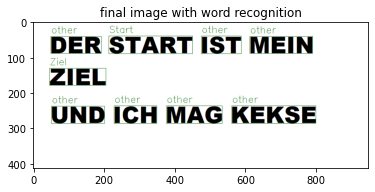

In [4]:
w_img = drawBoundingBoxForWord(copy_img, all_boundingboxes)
showimage(w_img, "final image with word recognition")